# Setup

In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2


In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
restore_model=True
train_model=False

In [4]:
import sys 
root = "/lhome/ific/a/aamerio/github/cfm-jax"
sys.path.append(f"{root}/examples/sbi-benchmarks")
sys.path.append(f"{root}/src")

In [5]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = f"{root}/examples/sbi-benchmarks/two_moons"
checkpoint_dir = f"{notebook_path}/checkpoints/two_moons_simformer"

os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from optax.contrib import reduce_on_plateau

from numpyro import distributions as dist

from corner import corner

import numpy as np

from tqdm.auto import tqdm

from functools import partial


/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 1e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [8]:
from sbi_utils.sbi_tasks import TwoMoons
from sbi_utils.dataloader import InfiniteDataLoader

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver

define the task

In [9]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()

In [10]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

In [11]:
reference_samples = task.get_reference_posterior_samples(num_observation=8)

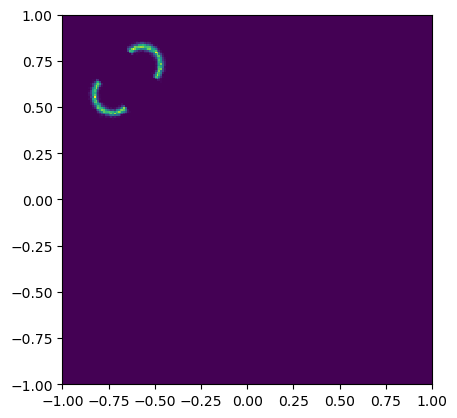

In [12]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# dataset

In [13]:
# make a dataset
nsamples = int(1e5)
val_size = 512
theta = prior.sample((nsamples+val_size,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)


train_data = data[:nsamples]
val_data = data[nsamples:]


In [14]:
batch_size = 4*1024 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
dataset = InfiniteDataLoader(train_data, batch_size, rng=nnx.Rngs(0).dataset())

# define the CFM model

In [15]:
from models import Simformer, SimformerParams, SimformerCFMLoss, SimformerConditioner

In [16]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [17]:
dim_joint = len(twomoons.get_node_id())

In [18]:
params = SimformerParams(
    rngs = nnx.Rngs(0),
    dim_value = 40,
    dim_id = 40, 
    dim_condition = 12, 
    dim_joint= dim_joint,
    fourier_features = 128,
    num_heads = 4,
    num_layers = 6,
    widening_factor = 3,
    qkv_features = 40, # this bottlenecks the transformer features to 40, instead of the token dimension
    num_hidden_layers = 1,
    dropout_rate = 0.0)

In [19]:
loss_fn_cfm = SimformerCFMLoss(path)

In [20]:
def marginalize(rng: jax.random.PRNGKey, edge_mask: jax.Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

In [21]:
undirected_edge_mask = twomoons.get_edge_mask_fn("undirected")(node_ids, None)
posterior_faithfull = twomoons.get_edge_mask_fn("faithfull")(node_ids, condition_mask=jnp.array([0,0,1,1]))

In [22]:
@partial(jax.jit, static_argnames=["nsamples"])
def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
    mask_joint = jnp.zeros((5*nsamples, dim_joint ), dtype=jnp.bool_)
    mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    # mask_likelihood = jnp.concatenate([jnp.ones((nsamples, dim_theta), dtype=jnp.bool_), jnp.zeros((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
    mask1 = jax.random.bernoulli(rng, p=0.3, shape=(nsamples, dim_joint))
    filter = ~jnp.all(mask1, axis=-1)
    mask1 = jnp.logical_and(mask1, filter.reshape(-1,1))

    # masks = jnp.concatenate([mask_joint, mask1, mask_posterior, mask_likelihood], axis=0)
    masks = jnp.concatenate([mask_joint, mask1, mask_posterior], axis=0)
    return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)
    

In [23]:
p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [24]:
def loss_fn_(vf_model, x_1, key: jax.random.PRNGKey):

    batch_size = x_1.shape[0]

    rng_x0, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    x_0 = p0_dist_model.sample(rng_x0, (batch_size,)) # n, T_max, 1
    
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask


    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_cfm(vf_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss

In [25]:
@nnx.jit
def train_loss(vf_model, key: jax.random.PRNGKey):
    x_1 = next(dataset) # n, T_max, 1
    return loss_fn_(vf_model, x_1, key)

In [26]:
@nnx.jit
def val_loss(vf_model, key):
    x_1 = val_data
    return loss_fn_(vf_model, x_1, key)

In [27]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [28]:
vf_model = Simformer(params)

In [29]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_simformer/1/metrics/metrics not found.
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restored model from checkpoint


In [30]:
# # linear learning rate schedule
# nsteps = 10_000 
# nepochs = 5


# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, 40000, 10000)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# # opt = optax.MultiSteps(opt, 2)

# optimizer = nnx.Optimizer(vf_model, opt)

In [31]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 5

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [32]:
rngs = nnx.Rngs(0)

In [33]:
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

early_stopping = True

In [34]:
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break

            loss = train_step(vf_model, optimizer, rngs.train_step())
            l += loss.item()
            
            v_loss = val_loss(vf_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(vf_model)
                    counter = 0
                else:
                    counter += 1

                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

            # if j>0 and j%3000 == 0:
            #     idx = 8
            #     vf_wrapped = FluxWrapper(vf_model)
            #     samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
            #     plot_samples(samples, true_param)
        # print(l)

    vf_model.eval()

In [35]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=True,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

In [36]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

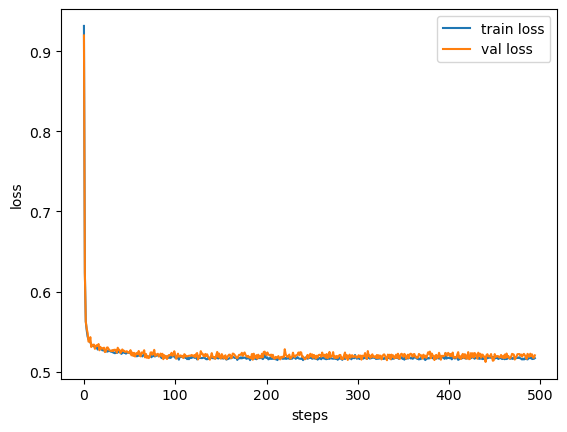

# sample the posterior

In [37]:
from utils.model_wrapping import ModelWrapper, GuidedModelWrapper
class SimWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        return self.model(obs=x, timesteps=t, **kwargs)

class GuidedSimWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale):
        super().__init__(model, cfg_scale)

    def __call__(self, x, t, args, **kwargs):
        return self.model(obs=x, timesteps=t, **kwargs)

In [38]:
obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
step_size = 0.01

# conditional sampling
def get_samples(vf_wrapped, idx, nsamples=10_000, edge_mask=posterior_faithfull):
    observation =  jnp.array(twomoons.get_observation(idx))
    true_param = jnp.array(task.get_true_parameters(idx))
    reference_samples = task.get_reference_posterior_samples(num_observation=idx)

    rng = jax.random.PRNGKey(45)

    key1,key2 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_theta)) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (1, dim_x, 1)) # n, dim_theta, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": edge_mask}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()

In [39]:
vf_cond = SimformerConditioner(vf_model)
vf_wrapped = SimWrapper(vf_cond)

In [40]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8
observation = jnp.array(twomoons.get_observation(idx))
reference_samples = task.get_reference_posterior_samples(num_observation=idx)

In [41]:
samples = get_samples(vf_wrapped, idx, nsamples=100_000)[0]
# samples, true_param, reference_samples = get_samples(vf_wrapped, idx, nsamples=10)

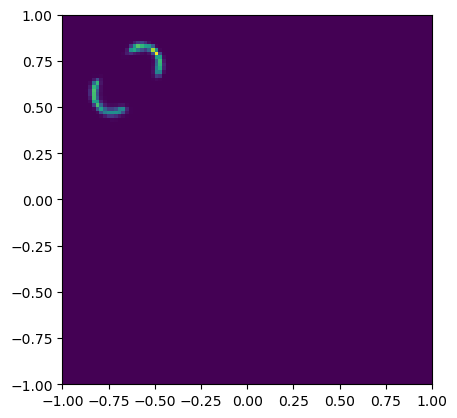

In [42]:
posterior_samples = samples

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=100, range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
plt.show()

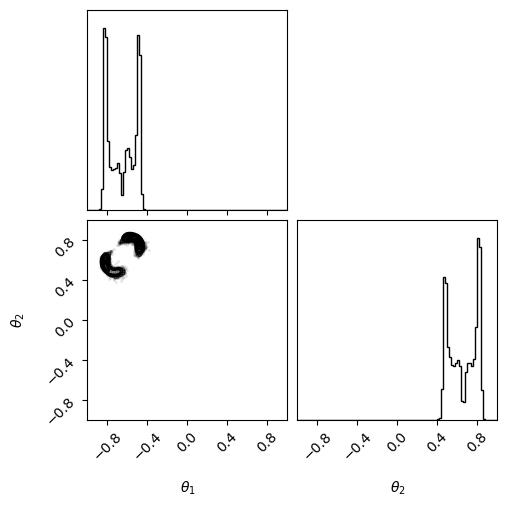

In [43]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

/tmp/ipykernel_70914/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


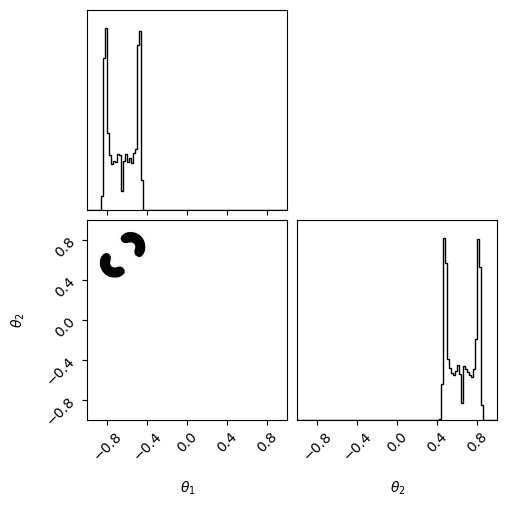

In [44]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# evaluate the posterior

In [45]:
idx = 8
observation = jnp.array(twomoons.get_observation(idx))
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

In [46]:
p0_cond = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [47]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

# cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta,1)) # n, dim_theta, 1
# cond = jnp.broadcast_to(observation, (x_1.shape[0], dim_theta)) # n, dim_theta, 1
cond = jnp.broadcast_to(observation, (1, dim_theta)) # n, dim_theta, 1

obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": posterior_faithfull}

In [48]:
# get the logprob
# logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_cond.log_prob, model_extras=model_extras)
# create an y_init which has theta on the first position and x1,x2 on the second and third position

# y_init = p0_cond.sample(jax.random.PRNGKey(0), (x_1.shape[0],))  # n, dim_theta
y_init = x_1

exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]


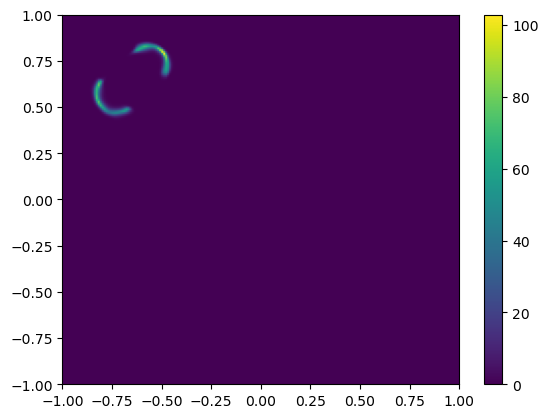

In [49]:
p_grid = p.reshape((grid_size, grid_size))
plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.colorbar()
plt.show()

# sample with guidance

In [50]:
gvf_wrapped = GuidedSimWrapper(vf_cond, cfg_scale=0.95)

In [51]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8


In [52]:
samples = get_samples(gvf_wrapped, idx, nsamples=100_000, edge_mask=None)[0]

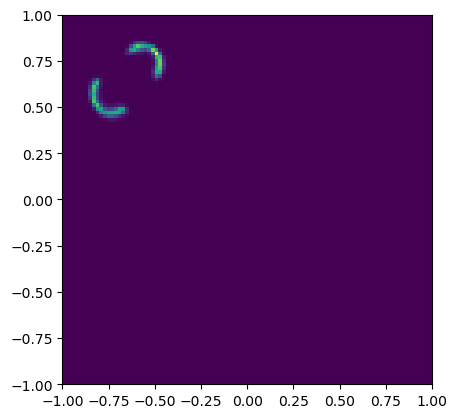

In [53]:
posterior_samples = samples

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=100, range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
plt.show()

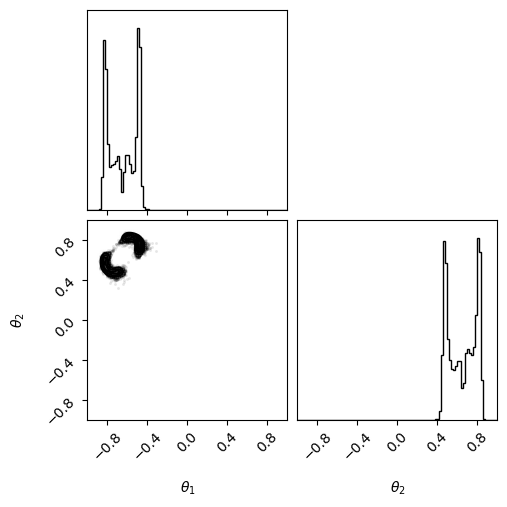

In [54]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# C2ST test

In [55]:
from sbibm.metrics import c2st

In [56]:
# convert posterior samples to a torch array
import torch
idx = 2
reference_samples = task.get_reference_posterior_samples(num_observation=idx)
posterior_samples = get_samples(vf_wrapped, idx, nsamples=reference_samples.shape[0])[0]
posterior_samples_torch = torch.tensor(np.array(posterior_samples), dtype=torch.float32)

posterior_samples_cfg = get_samples(gvf_wrapped, idx, nsamples=reference_samples.shape[0], edge_mask=None)[0]
posterior_samples_cfg_torch = torch.tensor(np.array(posterior_samples_cfg), dtype=torch.float32)

In [57]:
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
c2st_accuracy_cfg = c2st(reference_samples, posterior_samples_cfg_torch)

In [58]:
c2st_accuracy, c2st_accuracy_cfg

(tensor([0.5395]), tensor([0.5276]))